### Import the relevant libraries

In [1]:
import pandas as pd 
import numpy as np
import math
import keras
import tensorflow as tf
import progressbar
import os
from os import listdir
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization

### Functions

$\texttt{balance_data}$: This function allows us to balance the dataset by using the oversampling technique based on the predictor variables.

In [2]:
def balance_data(class_data, nbins):

    from matplotlib import pyplot as plt
    y = class_data[:,0]
    n, edges, _ = plt.hist(y, bins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max())
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[0] > edges_min and class_[0] < edges_max:
                for j in range(int(n_max/(n[i]))):
                    data.append(class_)
                break
        bar.update(k+1)
    bar.finish()
    plt.title('Balanced data ')
    return np.array(data)

$\texttt{prepare_data}$: split the dataset in $\text{[x_train, y_train, x_val, y_val] }$ where yy are the targets and xx are inputs

In [3]:
def prepare_data(class_data): 
    np.random.shuffle(class_data)
    y = class_data[:,0]
    x = class_data[:,1:10]
    train_split = 0.85
    train_limit = int(len(y)*train_split)
    print("Training sample of: {0} \nValuation sample: {1}".format(train_limit, len(y)-train_limit))
    x_train = x[:train_limit]
    x_val = x[train_limit:]
    y_train = y[:train_limit]
    y_val = y[train_limit:]
    if np.isnan(np.min(y)) == False:
        return x_train, y_train, x_val, y_val

$\texttt{plot_histo}$: Plots the data before balancing

In [4]:
def plot_histo(x, y, bins,logscale):
    y = np.array(y)
    plt.hist(y, bins, color = 'indianred', alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    if logscale == 1:
        plt.yscale('log')
    plt.title('Unbalanced data ')
    plt.show()

$\texttt{plot_history}$: Plots the loss function and the Kullback–Leibler divergence of every epoch.  The Kullback–Leibler divergence, (also called relative entropy), is a measure of how one probability distribution is different from a second, reference probability distribution.

In [5]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['kullback_leibler_divergence']
    val_accuracy = history.history['val_kullback_leibler_divergence']


    epochs = range(1, len(loss) + 1)
    fig, ax1 = plt.subplots()

    l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
    vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (mape)')

    ax2 = ax1.twinx()
    ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training KL div.')
    vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation KL div.')
    ax2.set_ylabel('Kullback Leibler divergence')

    lns = l1 + vl1 + ac2 + vac2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc="center right")
    fig.tight_layout()
    fig.show()

$\texttt{data_vel}$: create a dataset for a specific initial velocity

In [6]:
def data_vel(v): 
    v= np.random.uniform(v,v,(observations))
    x= np.linspace(0,100, (observations)) #gcm^-2
    skin=np.linspace(10**(-5),10, (observations))
    generated_data1 = np.array([multiple(v,x,skin),v,x,skin])
    data1 = np.transpose(generated_data1)
    targets=data1[:,:1]
    inputs = data1[:,1:]
    return targets, inputs

$\texttt{data_vel_range}$: create a dataset for a specific range of initial velocities

In [7]:
def data_skin_range(skin_min,skin_max): 
    v=np.random.uniform(0, 1, (observations))
    x= np.random.uniform(0,100, (observations)) #gcm^-2
    skin=np.linspace(skin_min,skin_max, (observations))
    generated_data1 = np.array([multiple(v,x,skin),v,x,skin])
    data1 = np.transpose(generated_data1)
    x0_train, y0_train, x0_val, y0_val = prepare_data(data1)
    return x0_train, y0_train, x0_val, y0_val

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\mean}[1]{\left\langle{#1}\right\rangle}
$
### Multiple Scattering

The Rutherford differential cross section describes the interaction between a particle of charge $z$ and an atomic nucleus
with atomic number $Z$, as a function of the scattering angle $\theta$:
\begin{equation}
\frac{d \sigma}{d\Omega} = \Big(\frac{zZe^2}{16\pi\epsilon_0E_k}\Big)^2 \times \frac{1}{\sin^4(\theta/2)} 
\end{equation}
Here $E_k$ denotes the kinetic energy of the charged particle.

From the Rutherford formulation it is clear that the cross section diverges at small angles. This implies that the average scattering angle is $\mean{\theta}  = 0$ . Under the hypothesis that a particle undergoes multiple independent scatterings
in a material, it is reasonable to assume the mean scattering angle to be Gaussian distributed. 
###### So, the standard deviation (or the variance) of this Gaussian is the relevant experimental quantity, as a beam of particles traveling in matter will somehow be “spread” by that amount.

And the expression is:
\begin{equation}
\sqrt{\mean{\theta^2}} = z \frac{E_s}{p \nu}\sqrt{\frac{x}{X_0}}
\end{equation}
Where $z$ is the charge of the particle being scattered, $E_s = 21MeV$, $X_0$ is the material's radiation length, $\rho$ is the scattered particle's momentum, $x$ is the material thickness and $\nu$ the particle's initial velocity.

#####  Plasma scenario
The radiation length is a measure of how deep does an EM wave penetrate a material, so the field follows an exponential decay. This is obtained from Beer-Lambert’s law, which can help us connect the radiation length to another well known parameter: the skin depth. <br>
The radiation length is twice the skin depth:
\begin{equation}
\ X_0 = 2 \frac{c}{\omega_p}
\end{equation}
where $c$ is the speed of light and $\omega_p$ the plasma frequency. 

$\texttt{multiple}$: This function receives the initial velocity, the material thickness and the skin depth and devolves the standard deviation according to Rutherford Multiple Scattering

In [8]:
def multiple(v, x,skin): 
    z= 2 # For an alpha particle
    Es = 21 # MeV
    # For Au
    Z = 79
    #mass of an alpha particle
    m= 938.27*2+939.56*2 # MeV
    X0=2*skin
    #momentum
    p = m*v
    
    return z*Es*np.sqrt(x/X0)/(p*v)

In [9]:
multiple (0.9, 3,0.004)

0.2673582788274716

### Generate the dataset

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\mean}[1]{\left\langle{#1}\right\rangle}
$   
The structure of the data set is as follows: $\newline$
 \begin{equation}
 \Big[\mean{\theta^2} \text{, v , x, skin depth} \Big]
 \end{equation}
 
Where  $\mean{\theta^2}$ is the standard deviation of the angular distribution (the target of our network), $v$ is the initial velocity and $x$ is the thickness of the material. 

In [10]:
# First, we should declare a variable containing the size of the training set we want to generate.
observations = 100000

# We will work with two variables as inputs.
# We generate them randomly, drawing from an uniform distribution.
v= np.random.uniform(0.2,1, (observations)) #C
x= np.random.uniform(0,100, (observations)) #gcm^-2
skin=np.linspace(10**(-5),10, (observations))

generated_data = np.array([multiple(v,x,skin),v,x,skin])
data = np.transpose(generated_data)

### Probability distributions (non balanced)

In [11]:
x0_train, y0_train, x0_val, y0_val = prepare_data(data)

Training sample of: 85000 
Valuation sample: 15000


In [12]:
print(x0_train.shape)
print(y0_train.shape)
print(x0_val.shape)
print(y0_val.shape)

(85000, 3)
(85000,)
(15000, 3)
(15000,)


No handles with labels found to put in legend.


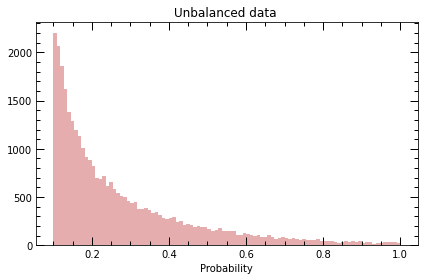

In [13]:
bins = np.linspace(0.1, 1, 100)
plot_histo(x0_train,y0_train,bins,0)

### Balancing of the data

[===========================================================================================================================================] 100% of 100000


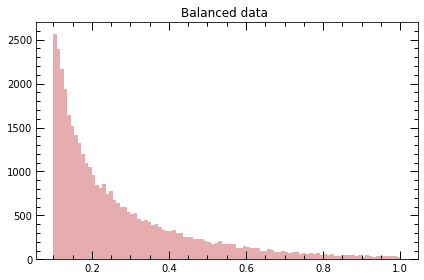

In [14]:
data_b = balance_data(data, 100)

### Split the data
85% for train and 15% for validation

In [15]:
x0_train, y0_train, x0_val, y0_val = prepare_data(data_b)

Training sample of: 202394 
Valuation sample: 35717


In [16]:
print(x0_train.shape)
print(y0_train.shape)
print(x0_val.shape)
print(y0_val.shape)

(202394, 3)
(202394,)
(35717, 3)
(35717,)


## Model Building

In [17]:
def build_model() :
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 3))
    model.add (layers.Dense (16 , activation = "relu"))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (64, activation = "relu"))
    model.add (layers.Dense (32, activation = "relu"))
    model.add (layers.Dense (16 , activation = "relu"))
    model.add (layers.Dense (1))
    model.compile(optimizer = "adam" , loss = 'mape' , metrics = [tf.keras.metrics.KLDivergence()])
    return model

In [18]:
model = build_model ()
history0 = model.fit ( x0_train, y0_train, epochs = 200, batch_size = 10000 , validation_data = (x0_val, y0_val) )

2021-09-28 18:05:33.298512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-28 18:05:33.509257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
21/21 [==============================] - 11s 26ms/step - loss: 69.5936 - kullback_leibler_divergence: 1.2079 - val_loss: 226.7876 - val_kullback_leibler_divergence: 0.4717
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 27.9322 - kullback_leibler_divergence: 0.3819 - val_loss: 65.0707 - val_kullback_leibler_divergence: 0.2680
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 15.1132 - kullback_leibler_divergence: 0.2394 - val_loss: 41.0733 - val_kullback_leibler_divergence: 0.2012
Epoch 4/200
21/21 [==============================] - 0s 6ms/step - loss: 12.1875 - kullback_leibler_divergence: 0.1902 - val_loss: 40.5085 - val_kullback_leibler_divergence: 0.1703
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 10.6938 - kullback_leibler_divergence: 0.1635 - val_loss: 39.4519 - val_kullback_leibler_divergence: 0.1511
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 9.3401 - kullback_l

21/21 [==============================] - 0s 6ms/step - loss: 3.6160 - kullback_leibler_divergence: 0.0391 - val_loss: 3.7134 - val_kullback_leibler_divergence: 0.0387
Epoch 47/200
21/21 [==============================] - 0s 6ms/step - loss: 3.1075 - kullback_leibler_divergence: 0.0385 - val_loss: 2.8314 - val_kullback_leibler_divergence: 0.0380
Epoch 48/200
21/21 [==============================] - 0s 7ms/step - loss: 3.1468 - kullback_leibler_divergence: 0.0378 - val_loss: 3.5404 - val_kullback_leibler_divergence: 0.0374
Epoch 49/200
21/21 [==============================] - 0s 7ms/step - loss: 3.5246 - kullback_leibler_divergence: 0.0372 - val_loss: 4.8903 - val_kullback_leibler_divergence: 0.0368
Epoch 50/200
21/21 [==============================] - 0s 7ms/step - loss: 3.8331 - kullback_leibler_divergence: 0.0367 - val_loss: 3.0465 - val_kullback_leibler_divergence: 0.0363
Epoch 51/200
21/21 [==============================] - 0s 6ms/step - loss: 3.3853 - kullback_leibler_divergence: 0

21/21 [==============================] - 0s 6ms/step - loss: 3.2933 - kullback_leibler_divergence: 0.0170 - val_loss: 5.4415 - val_kullback_leibler_divergence: 0.0169
Epoch 137/200
21/21 [==============================] - 0s 6ms/step - loss: 3.7646 - kullback_leibler_divergence: 0.0169 - val_loss: 1.6987 - val_kullback_leibler_divergence: 0.0168
Epoch 138/200
21/21 [==============================] - 0s 6ms/step - loss: 2.8548 - kullback_leibler_divergence: 0.0168 - val_loss: 2.4995 - val_kullback_leibler_divergence: 0.0168
Epoch 139/200
21/21 [==============================] - 0s 6ms/step - loss: 3.0304 - kullback_leibler_divergence: 0.0167 - val_loss: 2.8303 - val_kullback_leibler_divergence: 0.0167
Epoch 140/200
21/21 [==============================] - 0s 6ms/step - loss: 3.2134 - kullback_leibler_divergence: 0.0166 - val_loss: 2.4736 - val_kullback_leibler_divergence: 0.0166
Epoch 141/200
21/21 [==============================] - 0s 6ms/step - loss: 3.0187 - kullback_leibler_divergen

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

/var/folders/39/nrwg75cj18j8ts5cl835lrrr0000gn/T/ipykernel_13460/4069373605.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


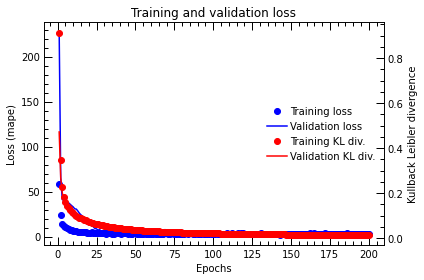

In [20]:
plot_history(history0)

### Prediction

In [21]:
y_pred0 = model.predict(x0_val)

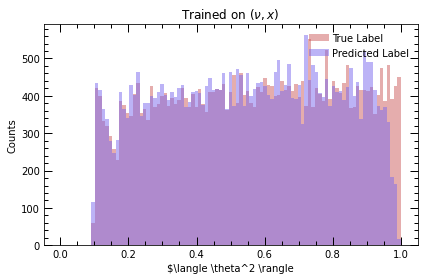

In [22]:
from matplotlib import pyplot
y0_val = np.array(y0_val)
bins = np.linspace(0.0004, 1, 100)
pyplot.hist(y0_val, bins, color = 'indianred', alpha=0.5, label='True Label')
pyplot.hist(y_pred0, bins, color = 'mediumslateblue', alpha=0.5, label='Predicted Label')
#pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('$\\langle \\theta^2 \\rangle')
pyplot.ylabel('Counts')
pyplot.title('Trained on ($ \\nu , x $)')
pyplot.show()

### Predictions for $\langle \theta^2 \rangle$ vs $  (v)$

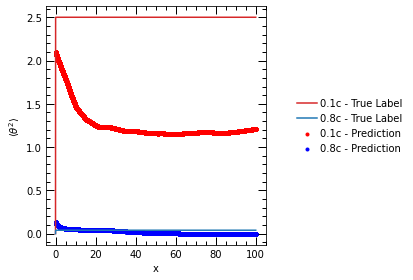

In [23]:
targets_v1, inputs_v1 = data_vel(0.1)
pred_targets_v1 = model.predict(inputs_v1)

targets_v2, inputs_v2 = data_vel(0.8)
pred_targets_v2 = model.predict(inputs_v2)

fig, ax = plt.subplots()

ax.scatter(inputs_v1[:,1], pred_targets_v1, marker='.', label='0.1c - Prediction', c='red')
ax.plot(inputs_v1[:,1], targets_v1, label='0.1c - True Label', c='tab:red')

ax.scatter(inputs_v2[:,1], pred_targets_v2, marker='.', label='0.8c - Prediction', c='b')
ax.plot(inputs_v2[:,1], targets_v2, label='0.8c - True Label', c='tab:blue')

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plt.savefig('prediction_multipleScattering.png',bbox_inches='tight')

plt.xlabel('x')
plt.ylabel('$\\langle \\theta^2 \\rangle$')
plt.show()

## Transfer Learning

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. <br>
So, we will divide the dataset into two parts: the first has values of skin depth from $0$ to $10^{-3}$ and then the second group has velocities from $10^{-3}$ to $1$.

In [24]:
x1_train, y1_train, x1_val, y1_val= data_skin_range(10**(-5), 10**(-1))

Training sample of: 85000 
Valuation sample: 15000


In [25]:
model_TL = build_model()
historyTL1 = model_TL.fit ( x1_train, y1_train, epochs = 200, batch_size = 1000 , validation_data = (x1_val, y1_val) )

Epoch 1/200
85/85 [==============================] - 1s 5ms/step - loss: 63.6944 - kullback_leibler_divergence: 0.9979 - val_loss: 62.9179 - val_kullback_leibler_divergence: 0.2006
Epoch 2/200
85/85 [==============================] - 0s 2ms/step - loss: 29.4113 - kullback_leibler_divergence: 0.1584 - val_loss: 52.1529 - val_kullback_leibler_divergence: 0.1031
Epoch 3/200
85/85 [==============================] - 0s 2ms/step - loss: 24.9780 - kullback_leibler_divergence: 0.0922 - val_loss: 45.1472 - val_kullback_leibler_divergence: 0.0723
Epoch 4/200
85/85 [==============================] - 0s 2ms/step - loss: 24.2309 - kullback_leibler_divergence: 0.0677 - val_loss: 35.8014 - val_kullback_leibler_divergence: 0.0574
Epoch 5/200
85/85 [==============================] - 0s 2ms/step - loss: 20.9760 - kullback_leibler_divergence: 0.0547 - val_loss: 30.7509 - val_kullback_leibler_divergence: 0.0480
Epoch 6/200
85/85 [==============================] - 0s 2ms/step - loss: 19.6300 - kullback_lei

85/85 [==============================] - 0s 2ms/step - loss: 12.2977 - kullback_leibler_divergence: 0.0083 - val_loss: 10.8561 - val_kullback_leibler_divergence: 0.0082
Epoch 47/200
85/85 [==============================] - 0s 2ms/step - loss: 13.1904 - kullback_leibler_divergence: 0.0082 - val_loss: 11.6868 - val_kullback_leibler_divergence: 0.0081
Epoch 48/200
85/85 [==============================] - 0s 2ms/step - loss: 13.3314 - kullback_leibler_divergence: 0.0081 - val_loss: 11.1964 - val_kullback_leibler_divergence: 0.0080
Epoch 49/200
85/85 [==============================] - 0s 2ms/step - loss: 13.1636 - kullback_leibler_divergence: 0.0080 - val_loss: 11.4398 - val_kullback_leibler_divergence: 0.0079
Epoch 50/200
85/85 [==============================] - 0s 2ms/step - loss: 12.9299 - kullback_leibler_divergence: 0.0079 - val_loss: 12.7584 - val_kullback_leibler_divergence: 0.0078
Epoch 51/200
85/85 [==============================] - 0s 2ms/step - loss: 12.6681 - kullback_leibler_di

85/85 [==============================] - 0s 2ms/step - loss: 12.5639 - kullback_leibler_divergence: 0.0048 - val_loss: 7.3414 - val_kullback_leibler_divergence: 0.0048
Epoch 137/200
85/85 [==============================] - 0s 2ms/step - loss: 11.9380 - kullback_leibler_divergence: 0.0048 - val_loss: 9.8844 - val_kullback_leibler_divergence: 0.0048
Epoch 138/200
85/85 [==============================] - 0s 2ms/step - loss: 12.7805 - kullback_leibler_divergence: 0.0048 - val_loss: 7.2558 - val_kullback_leibler_divergence: 0.0047
Epoch 139/200
85/85 [==============================] - 0s 2ms/step - loss: 12.5355 - kullback_leibler_divergence: 0.0047 - val_loss: 8.6553 - val_kullback_leibler_divergence: 0.0047
Epoch 140/200
85/85 [==============================] - 0s 2ms/step - loss: 11.6698 - kullback_leibler_divergence: 0.0047 - val_loss: 16.9419 - val_kullback_leibler_divergence: 0.0047
Epoch 141/200
85/85 [==============================] - 0s 2ms/step - loss: 11.6664 - kullback_leibler_d

85/85 [==============================] - 0s 2ms/step - loss: 11.7412 - kullback_leibler_divergence: 0.0043 - val_loss: 9.2347 - val_kullback_leibler_divergence: 0.0043
Epoch 182/200
85/85 [==============================] - 0s 2ms/step - loss: 13.2907 - kullback_leibler_divergence: 0.0043 - val_loss: 7.8378 - val_kullback_leibler_divergence: 0.0043
Epoch 183/200
85/85 [==============================] - 0s 2ms/step - loss: 10.7166 - kullback_leibler_divergence: 0.0043 - val_loss: 7.8071 - val_kullback_leibler_divergence: 0.0043
Epoch 184/200
85/85 [==============================] - 0s 2ms/step - loss: 10.8332 - kullback_leibler_divergence: 0.0043 - val_loss: 8.0529 - val_kullback_leibler_divergence: 0.0043
Epoch 185/200
85/85 [==============================] - 0s 2ms/step - loss: 10.5962 - kullback_leibler_divergence: 0.0043 - val_loss: 6.0437 - val_kullback_leibler_divergence: 0.0043
Epoch 186/200
85/85 [==============================] - 0s 2ms/step - loss: 11.0162 - kullback_leibler_di

/var/folders/39/nrwg75cj18j8ts5cl835lrrr0000gn/T/ipykernel_13460/4069373605.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


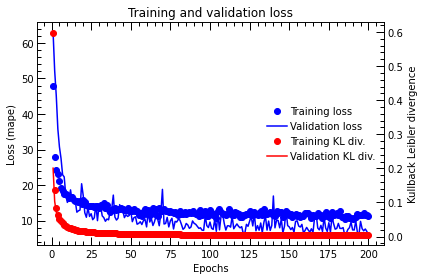

In [26]:
plot_history(historyTL1)

In [27]:
x2_train, y2_train, x2_val, y2_val= data_skin_range(10**(-4), 10**(-2))

Training sample of: 85000 
Valuation sample: 15000


In [28]:
model_TL.trainable = True
historyTL2 = model_TL.fit ( x2_train, y2_train, epochs = 200, batch_size = 1000 , validation_data = (x2_val, y2_val) )

Epoch 1/200
85/85 [==============================] - 0s 2ms/step - loss: 45.9062 - kullback_leibler_divergence: 0.0046 - val_loss: 32.1534 - val_kullback_leibler_divergence: 0.0047
Epoch 2/200
85/85 [==============================] - 0s 2ms/step - loss: 26.5767 - kullback_leibler_divergence: 0.0047 - val_loss: 30.4287 - val_kullback_leibler_divergence: 0.0047
Epoch 3/200
85/85 [==============================] - 0s 2ms/step - loss: 24.7607 - kullback_leibler_divergence: 0.0047 - val_loss: 22.2623 - val_kullback_leibler_divergence: 0.0047
Epoch 4/200
85/85 [==============================] - 0s 2ms/step - loss: 21.9719 - kullback_leibler_divergence: 0.0047 - val_loss: 20.5949 - val_kullback_leibler_divergence: 0.0047
Epoch 5/200
85/85 [==============================] - 0s 2ms/step - loss: 19.5617 - kullback_leibler_divergence: 0.0047 - val_loss: 18.8387 - val_kullback_leibler_divergence: 0.0047
Epoch 6/200
85/85 [==============================] - 0s 2ms/step - loss: 18.7822 - kullback_lei

85/85 [==============================] - 0s 2ms/step - loss: 11.5524 - kullback_leibler_divergence: 0.0039 - val_loss: 7.8271 - val_kullback_leibler_divergence: 0.0039
Epoch 92/200
85/85 [==============================] - 0s 2ms/step - loss: 11.3501 - kullback_leibler_divergence: 0.0039 - val_loss: 6.5904 - val_kullback_leibler_divergence: 0.0039
Epoch 93/200
85/85 [==============================] - 0s 2ms/step - loss: 11.6065 - kullback_leibler_divergence: 0.0039 - val_loss: 8.6008 - val_kullback_leibler_divergence: 0.0039
Epoch 94/200
85/85 [==============================] - 0s 2ms/step - loss: 11.2787 - kullback_leibler_divergence: 0.0039 - val_loss: 9.1482 - val_kullback_leibler_divergence: 0.0039
Epoch 95/200
85/85 [==============================] - 0s 2ms/step - loss: 11.5485 - kullback_leibler_divergence: 0.0039 - val_loss: 7.0079 - val_kullback_leibler_divergence: 0.0039
Epoch 96/200
85/85 [==============================] - 0s 2ms/step - loss: 11.1137 - kullback_leibler_diverge

85/85 [==============================] - 0s 2ms/step - loss: 11.0644 - kullback_leibler_divergence: 0.0035 - val_loss: 6.2455 - val_kullback_leibler_divergence: 0.0035
Epoch 182/200
85/85 [==============================] - 0s 2ms/step - loss: 11.6316 - kullback_leibler_divergence: 0.0035 - val_loss: 8.1143 - val_kullback_leibler_divergence: 0.0035
Epoch 183/200
85/85 [==============================] - 0s 2ms/step - loss: 11.2565 - kullback_leibler_divergence: 0.0035 - val_loss: 7.6547 - val_kullback_leibler_divergence: 0.0035
Epoch 184/200
85/85 [==============================] - 0s 2ms/step - loss: 10.5736 - kullback_leibler_divergence: 0.0035 - val_loss: 7.0523 - val_kullback_leibler_divergence: 0.0035
Epoch 185/200
85/85 [==============================] - 0s 2ms/step - loss: 10.8738 - kullback_leibler_divergence: 0.0035 - val_loss: 6.7225 - val_kullback_leibler_divergence: 0.0035
Epoch 186/200
85/85 [==============================] - 0s 2ms/step - loss: 11.0915 - kullback_leibler_di

/var/folders/39/nrwg75cj18j8ts5cl835lrrr0000gn/T/ipykernel_13460/4069373605.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


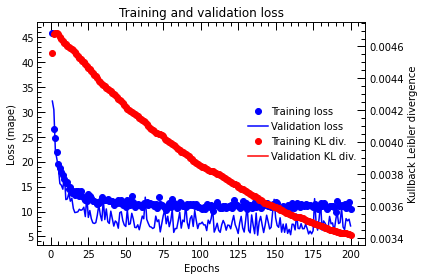

In [29]:
plot_history(historyTL2)

##  Comparison of both the Gaussians (from prediction & the analytical calculation)

In [30]:
def predictAgularSD(model, velocity, length, skin):
    feat = np.array([[velocity,length, skin]])
    prediction = model.predict(feat)
    return prediction[0][0]

In [31]:
predictAgularSD(model_TL, 0.1, 20, 0.005)

44.135105

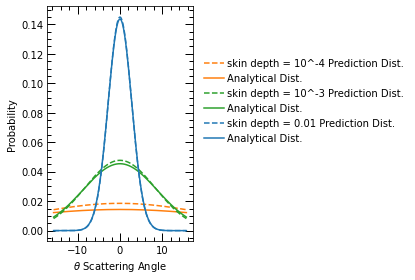

In [37]:
theta = np.linspace(-5*np.pi,5*np.pi,1000)


predicted_sd_x5 = predictAgularSD(model_TL, 0.3, 10, 10**(-4))
true_sd_x5 = multiple(0.3, 10,10**(-4))

plt.plot(theta, 1/(predicted_sd_x5 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x5**2) ),
        linestyle='dashed', c='tab:orange', label='skin depth = 10^-4 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x5 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x5**2) ),
        c='tab:orange', label='Analytical Dist.')



predicted_sd_x20 = predictAgularSD(model_TL, 0.3, 10, 10**(-3))
true_sd_x20 = multiple(0.3, 10, 10**(-3))

plt.plot(theta, 1/(predicted_sd_x20 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x20**2) ),
        linestyle='dashed', c='tab:green', label='skin depth = 10^-3 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x20 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x20**2) ),
        c='tab:green', label='Analytical Dist.')

predicted_sd_x50 = predictAgularSD(model_TL, 0.3, 10, 0.01)
true_sd_x50 = multiple(0.3, 10, 0.01)

plt.plot(theta, 1/(predicted_sd_x50 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * predicted_sd_x50**2) ),
        linestyle='dashed', c='tab:blue', label='skin depth = 0.01 Prediction Dist.')
plt.plot(theta, 1/(true_sd_x50 * np.sqrt(2 * np.pi)) * np.exp( - theta**2 / (2 * true_sd_x50**2) ),
        c='tab:blue', label='Analytical Dist.')


plt.xlabel('$\\theta$ Scattering Angle')
plt.ylabel('Probability')
plt.legend(loc=[1.05,0.4])
plt.show()